## 简介：
数据集notMNIST，和MNIST不同的是它是一个各种形态的字母的数据集合，总共有a~j 10个字母组成

![notMnist数据集](./picture/notMnist.png "notMnist数据集")


### 加载相关包

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tarfile
from IPython.display import display, Image
from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle

# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline

extract the dataset from the compressed .tar.gz file. This should give you a set of directories, labeled A through J.

In [2]:
num_classes = 10
np.random.seed(133)

def maybe_extract(filename, force=False):
    root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
    if os.path.isdir(root) and not force:
        # You may override by setting force=True.
        print('%s already present - Skipping extraction of %s.' %
              (root, filename))
    else:
        print('Extracting data for %s. This may take a while. Please wait.' % root)
        tar = tarfile.open(filename)
        sys.stdout.flush()
        tar.extractall(data_root)
        tar.close()
    data_folders = [
        os.path.join(root, d) for d in sorted(os.listdir(root))
        if os.path.isdir(os.path.join(root, d))]
    if len(data_folders) != num_classes:
        raise Exception(
            'Expected %d folders, one per class. Found %d instead.' % (
                num_classes, len(data_folders)))
    print(data_folders)
    return data_folders


train_folders = maybe_extract('notMNIST_large.tar.gz')
test_folders = maybe_extract('notMNIST_small.tar.gz')

notMNIST_large already present - Skipping extraction of notMNIST_large.tar.gz.
['notMNIST_large/A', 'notMNIST_large/B', 'notMNIST_large/C', 'notMNIST_large/D', 'notMNIST_large/E', 'notMNIST_large/F', 'notMNIST_large/G', 'notMNIST_large/H', 'notMNIST_large/I', 'notMNIST_large/J']
notMNIST_small already present - Skipping extraction of notMNIST_small.tar.gz.
['notMNIST_small/A', 'notMNIST_small/B', 'notMNIST_small/C', 'notMNIST_small/D', 'notMNIST_small/E', 'notMNIST_small/F', 'notMNIST_small/G', 'notMNIST_small/H', 'notMNIST_small/I', 'notMNIST_small/J']


显示图片样本

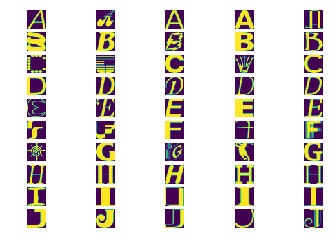

In [95]:
import random

#display(Image(filename="notMNIST_small/C/QmVlc2tuZWVzQy5vdGY=.png"))

def display_image(folders, num_class, num_image):
    if(num_image <= 0):
        print('num_image <= 0')
        return
    fig = plt.figure('subplot')
    for index,folder in enumerate(folders):
        images_name = random.sample(os.listdir(folder), num_image)
        images_path = [os.path.join(folder, elm) for elm in images_name]
        
        for i,image_file in enumerate(images_path):
            ax = fig.add_subplot(num_class, num_image, index*num_image+i+1)
            image = (imageio.imread(image_file)).astype(float)
            ax.imshow(image)
            ax.set_axis_off()
        index = index+1  
    plt.show()
    
#显示10类，每类显示5张图片         
display_image(train_folders, 10, 5) 

## problem1
Let's take a peek at some of the data to make sure it looks sensible. Each exemplar should be an image of a character A through J rendered in a different font. Display a sample of the images that we just downloaded. Hint: you can use the package IPython.display.

---
Now let's load the data in a more manageable format. Since, depending on your computer setup you might not be able to fit it all in memory, we'll load each class into a separate dataset, store them on disk and curate them independently. Later we'll merge them into a single dataset of manageable size.

We'll convert the entire dataset into a 3D array (image index, x, y) of floating point values, normalized to have approximately zero mean and standard deviation ~0.5 to make training easier down the road.

A few images might not be readable, we'll just skip them.

In [4]:
image_size = 28  # iPixel width and height.
pixel_depth = 255.0  # Number of levels per pixel.

def load_letter(folder, min_num_images):
    """Load the data for a single letter label."""
    image_files = os.listdir(folder)
    dataset = np.ndarray(shape=(len(image_files), image_size, image_size),
                         dtype=np.float32)
    print(folder)

    num_images = 0
    for image in image_files:
        image_file = os.path.join(folder, image)
        try:
            image_data = (imageio.imread(image_file).astype(float) - \
                          pixel_depth / 2) / pixel_depth

            if image_data.shape != (image_size, image_size):
                raise Exception('Unexpected image shape: %s' %
                                str(image_data.shape))
            dataset[num_images, :, :] = image_data
            num_images = num_images + 1
        except (IOError, ValueError) as e:
            print('Could not read:', image_file,
                  ':', e, '- it\'s ok, skipping.')

    dataset = dataset[0:num_images, :, :]
    if num_images < min_num_images:
        raise Exception('Many fewer images than expected: %d < %d' %
                        (num_images, min_num_images))

    print('Full dataset tensor:', dataset.shape)
    print('Mean:', np.mean(dataset))
    print('Standard deviation:', np.std(dataset))
    return dataset


def maybe_pickle(data_folders, min_num_images_per_class, force=False):
    dataset_names = []
    for folder in data_folders:
        set_filename = folder + '.pickle'
        dataset_names.append(set_filename)
        if os.path.exists(set_filename) and not force:
            # You may override by setting force=True.
            print('%s already present - Skipping pickling.' % set_filename)
        else:
            print('Pickling %s.' % set_filename)
            dataset = load_letter(folder, min_num_images_per_class)
            try:
                with open(set_filename, 'wb') as f:
                    pickle.dump(dataset, f, pickle.HIGHEST_PROTOCOL)
            except Exception as e:
                print('Unable to save data to', set_filename, ':', e)

    return dataset_names


train_datasets = maybe_pickle(train_folders, 45000)
test_datasets = maybe_pickle(test_folders, 1800)
print(train_datasets)

notMNIST_large/A.pickle already present - Skipping pickling.
notMNIST_large/B.pickle already present - Skipping pickling.
notMNIST_large/C.pickle already present - Skipping pickling.
notMNIST_large/D.pickle already present - Skipping pickling.
notMNIST_large/E.pickle already present - Skipping pickling.
notMNIST_large/F.pickle already present - Skipping pickling.
notMNIST_large/G.pickle already present - Skipping pickling.
notMNIST_large/H.pickle already present - Skipping pickling.
notMNIST_large/I.pickle already present - Skipping pickling.
notMNIST_large/J.pickle already present - Skipping pickling.
notMNIST_small/A.pickle already present - Skipping pickling.
notMNIST_small/B.pickle already present - Skipping pickling.
notMNIST_small/C.pickle already present - Skipping pickling.
notMNIST_small/D.pickle already present - Skipping pickling.
notMNIST_small/E.pickle already present - Skipping pickling.
notMNIST_small/F.pickle already present - Skipping pickling.
notMNIST_small/G.pickle 

## problem2
Let's verify that the data still looks good. Displaying a sample of the labels and images from the ndarray. Hint: you can use matplotlib.pyplot.

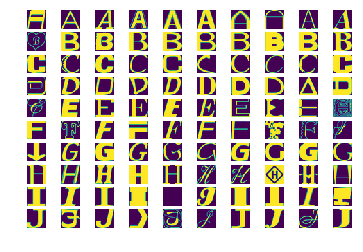

In [92]:
'''
with open('/home/l/桌面/notMNIST/notMNIST_large/B.pickle','rb') as pk_f:
    data_b = pickle.load(pk_f)
print(data_b.shape)
for i in range(0,1000,500):
    pic = data_b[i,:,:]
    plt.imshow(pic)
    plt.show()
'''
    
def display_image_from_pickle(dataset, num_class, num_image):
    if(num_image <= 0):
        print('num_image <= 0')
        return
    fig = plt.figure('subplot')
    for index,pickle_file in enumerate(dataset):
        with open(pickle_file,'rb') as f:
            data = pickle.load(f)
            #images = data[0:num_image,:,:]
            rs = np.random.choice(data.shape[0], num_image, replace=False) # 构建随机查看序列
            images = data[rs,:,:]
            for i,image in enumerate(images):
                #NumClass代表类别，每个类别一行;NumImage代表每个类显示的图像张数
                ax = fig.add_subplot(num_class, num_image, index*num_image+i+1)
                ax.imshow(image)
                ax.set_axis_off()
            index = index+1  
    plt.show()
    
#显示10类，每类显示5张图片        
#display_image_from_pickle(train_datasets,10,5)    
display_image_from_pickle(test_datasets, 10, 10) 

## Problem 3_1
Another check: we expect the data to be balanced across classes. Verify that.

In [6]:
file_path = "/home/l/桌面/notMNIST/notMNIST_large/{0}.pickle"

for name in "ABCDEFGHIJ":
    with open(file_path.format(name), 'rb') as pk_f:
        data = pickle.load(pk_f)
        print(name, data.shape)

A (52909, 28, 28)
B (52911, 28, 28)
C (52912, 28, 28)
D (52911, 28, 28)
E (52912, 28, 28)
F (52912, 28, 28)
G (52912, 28, 28)
H (52912, 28, 28)
I (52912, 28, 28)
J (52911, 28, 28)


## Problem 3_2
Merge and prune the training data as needed. Depending on your computer setup, you might not be able to fit it all in memory, and you can tune train_size as needed. The labels will be stored into a separate array of integers 0 through 9.

Also create a validation dataset for hyperparameter tuning

In [7]:
def make_arrays(nb_rows, img_size):
    if nb_rows:
        dataset = np.ndarray((nb_rows, img_size, img_size), dtype=np.float32)
        labels = np.ndarray(nb_rows, dtype=np.int32)
    else:
        dataset, labels = None, None
    return dataset, labels


def merge_datasets(pickle_files, train_size, valid_size=0):
    num_classes = len(pickle_files)
    valid_dataset, valid_labels = make_arrays(valid_size, image_size)
    train_dataset, train_labels = make_arrays(train_size, image_size)
    vsize_per_class = valid_size // num_classes
    tsize_per_class = train_size // num_classes

    start_v, start_t = 0, 0
    end_v, end_t = vsize_per_class, tsize_per_class
    end_l = vsize_per_class+tsize_per_class
    for label, pickle_file in enumerate(pickle_files):
        try:
            with open(pickle_file, 'rb') as f:
                letter_set = pickle.load(f)
                # let's shuffle the letters to have random validation and training set
                np.random.shuffle(letter_set)
                if valid_dataset is not None:
                    valid_letter = letter_set[:vsize_per_class, :, :]
                    valid_dataset[start_v:end_v, :, :] = valid_letter
                    valid_labels[start_v:end_v] = label
                    start_v += vsize_per_class
                    end_v += vsize_per_class

                train_letter = letter_set[vsize_per_class:end_l, :, :]
                train_dataset[start_t:end_t, :, :] = train_letter
                train_labels[start_t:end_t] = label
                start_t += tsize_per_class
                end_t += tsize_per_class
        except Exception as e:
            print('Unable to process data from', pickle_file, ':', e)
            raise

    return valid_dataset, valid_labels, train_dataset, train_labels


train_size = 200000
valid_size = 10000
test_size = 10000

valid_dataset, valid_labels, train_dataset, train_labels = merge_datasets(
    train_datasets, train_size, valid_size)
_, _, test_dataset, test_labels = merge_datasets(test_datasets, test_size)

print('Training:', train_dataset.shape, train_labels.shape)
print('Validation:', valid_dataset.shape, valid_labels.shape)
print('Testing:', test_dataset.shape, test_labels.shape)


Training: (200000, 28, 28) (200000,)
Validation: (10000, 28, 28) (10000,)
Testing: (10000, 28, 28) (10000,)


Next, we'll ***randomize the data***. It's important to have the labels well shuffled for the training and test distributions to match.

In [8]:
def randomize(dataset, labels):
    permutation = np.random.permutation(labels.shape[0])
    shuffled_dataset = dataset[permutation,:,:]
    shuffled_labels = labels[permutation]
    return shuffled_dataset, shuffled_labels
train_dataset, train_labels = randomize(train_dataset, train_labels)
test_dataset, test_labels = randomize(test_dataset, test_labels)
valid_dataset, valid_labels = randomize(valid_dataset, valid_labels)

## Problem 4
Convince yourself that the data is still good after shuffling!

----

Finally, let's save the data for later reuse:

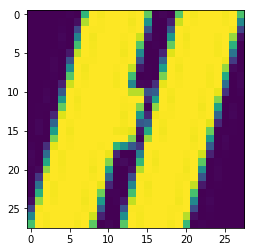

the pictrue is H


In [9]:
mapping = { key:val for key, val in enumerate('ABCDEFGHIJ') }

def plot_check(mat, key):
    plt.imshow(mat)
    plt.show()
    print('the pictrue is', mapping[key])


length = train_dataset.shape[0]-1

for _ in range(1):
    index = np.random.randint(length)
    plot_check(train_dataset[index,:,:], train_labels[index])

In [10]:
def save_data():
    pickle_file = os.path.join('.', 'notMNIST.pickle')
    
    if os.path.exists(pickle_file):
        print('%s already present.' %pickle_file)
        return None
        
    try:
        f = open(pickle_file, 'wb')
        save = {
            'train_dataset': train_dataset,
            'train_labels': train_labels,
            'valid_dataset': valid_dataset,
            'valid_labels': valid_labels,
            'test_dataset': test_dataset,
            'test_labels': test_labels,
        }
        pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
        f.close()
    except Exception as e:
        print('Unable to save data to', pickle_file, ':', e)
        raise
    statinfo = os.stat(pickle_file)
    print('Compressed pickle size:', statinfo.st_size)

save_data()

./notMNIST.pickle already present.


In [11]:
from multiprocessing import Process
import numpy as np
import collections
 

 


## Problem 6
Let's get an idea of what an off-the-shelf classifier can give you on this data. It's always good to check that there is something to learn, and that it's a problem that is not so trivial that a canned solution solves it.

Train a simple model on this data using 50, 100, 1000 and 5000 training samples. Hint: you can use the LogisticRegression model from sklearn.linear_model.

Optional question: train an off-the-shelf model on all the data!

In [97]:

with open('./notMNIST.pickle','rb') as f:
    data = pickle.load(f)

train_dataset = data['train_dataset']
train_labels = data['train_labels']
valid_dataset = data['valid_dataset']
valid_labels = data['valid_labels'] 
test_dataset = data['test_dataset']
test_labels = data['test_labels']

    
def train_and_predict(sample_size):
    regr = LogisticRegression(solver='liblinear', multi_class='ovr')
    
    x_train = train_dataset[:sample_size].reshape(sample_size,784)
    y_train = train_labels[:sample_size]
    regr.fit(x_train,y_train)
    
    x_test = test_dataset.reshape(test_dataset.shape[0],28*28)
    y_test = test_labels

    #pred_labels = regr.predict(x_test)
    print('Accuracy:', regr.score(x_test, y_test), 'when sample_size=', sample_size)

for sample_size in [50]:
    train_and_predict(sample_size)

Accuracy: 0.6425 when sample_size= 50


In [100]:
import tensorflow as tf
tf.__version__

'1.12.0'